In [1]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Load the model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
# checkpoint_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ViT_best.pth"
# state_dict = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if you're using GPU
# model.load_state_dict(state_dict)

model.eval()



# # Save the original forward method
# original_attn_forward = model.blocks[-1].attn.forward




c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [2]:
attn_weights = []

def patched_attn_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    q, k, v = qkv.permute(2, 0, 3, 1, 4)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    attn_weights.append(attn.detach())  # 💡 Save attention before dropout
    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

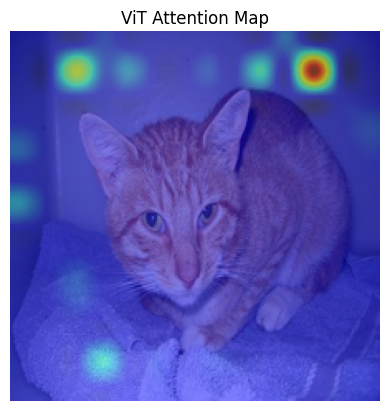

In [3]:
attn_weights = []


# Load and preprocess the image
image_path = r"C:\Users\e0l07sq\Downloads\training_set\training_set\cats\cat.119.jpg"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension


# Patch it
model.blocks[-1].attn.forward = patched_attn_forward.__get__(model.blocks[-1].attn, type(model.blocks[-1].attn))
# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Get the attention from the CLS token
attn = attn_weights[0]  # Shape: [batch, heads, tokens, tokens]
cls_attn = attn[0, :, 0, 1:]  # CLS to all patches, ignore CLS->CLS

# Average over heads
mean_attn = cls_attn.mean(dim=0).reshape(14, 14).cpu().numpy()  # ViT has 14x14 patches

# Normalize
mean_attn = (mean_attn - mean_attn.min()) / (mean_attn.max() - mean_attn.min())

# Upsample to image size
import cv2
attn_map = cv2.resize(mean_attn, (224, 224), interpolation=cv2.INTER_CUBIC)

# Show overlay
fig, ax = plt.subplots()
ax.imshow(img.resize((224, 224)))
ax.imshow(attn_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT Attention Map")
plt.show()

